Uczenie Maszynowe zadanie domowe

In [ ]:
!pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from medmnist import DermaMNIST
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
dataset_train = DermaMNIST(split='train', download=True)
dataset_val = DermaMNIST(split='val', download=True)
dataset_test = DermaMNIST(split='test', download=True)


dataset_x_all = np.concatenate((dataset_train.imgs, dataset_val.imgs, dataset_test.imgs), axis=0)
dataset_y_all = np.concatenate((dataset_train.labels, dataset_val.labels, dataset_test.labels), axis=0)

Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz


In [ ]:
print(f'Train Set:      X:%s Y:%s' %(dataset_train.imgs.shape, dataset_train.labels.shape))
print(f'Validation Set: X:%s Y:%s' %(dataset_val.imgs.shape, dataset_val.labels.shape))
print(f'Test Set :      X:%s Y:%s' %(dataset_test.imgs.shape, dataset_test.labels.shape))

Train Set:      X:(7007, 28, 28, 3) Y:(7007, 1)
Validation Set: X:(1003, 28, 28, 3) Y:(1003, 1)
Test Set :      X:(2005, 28, 28, 3) Y:(2005, 1)


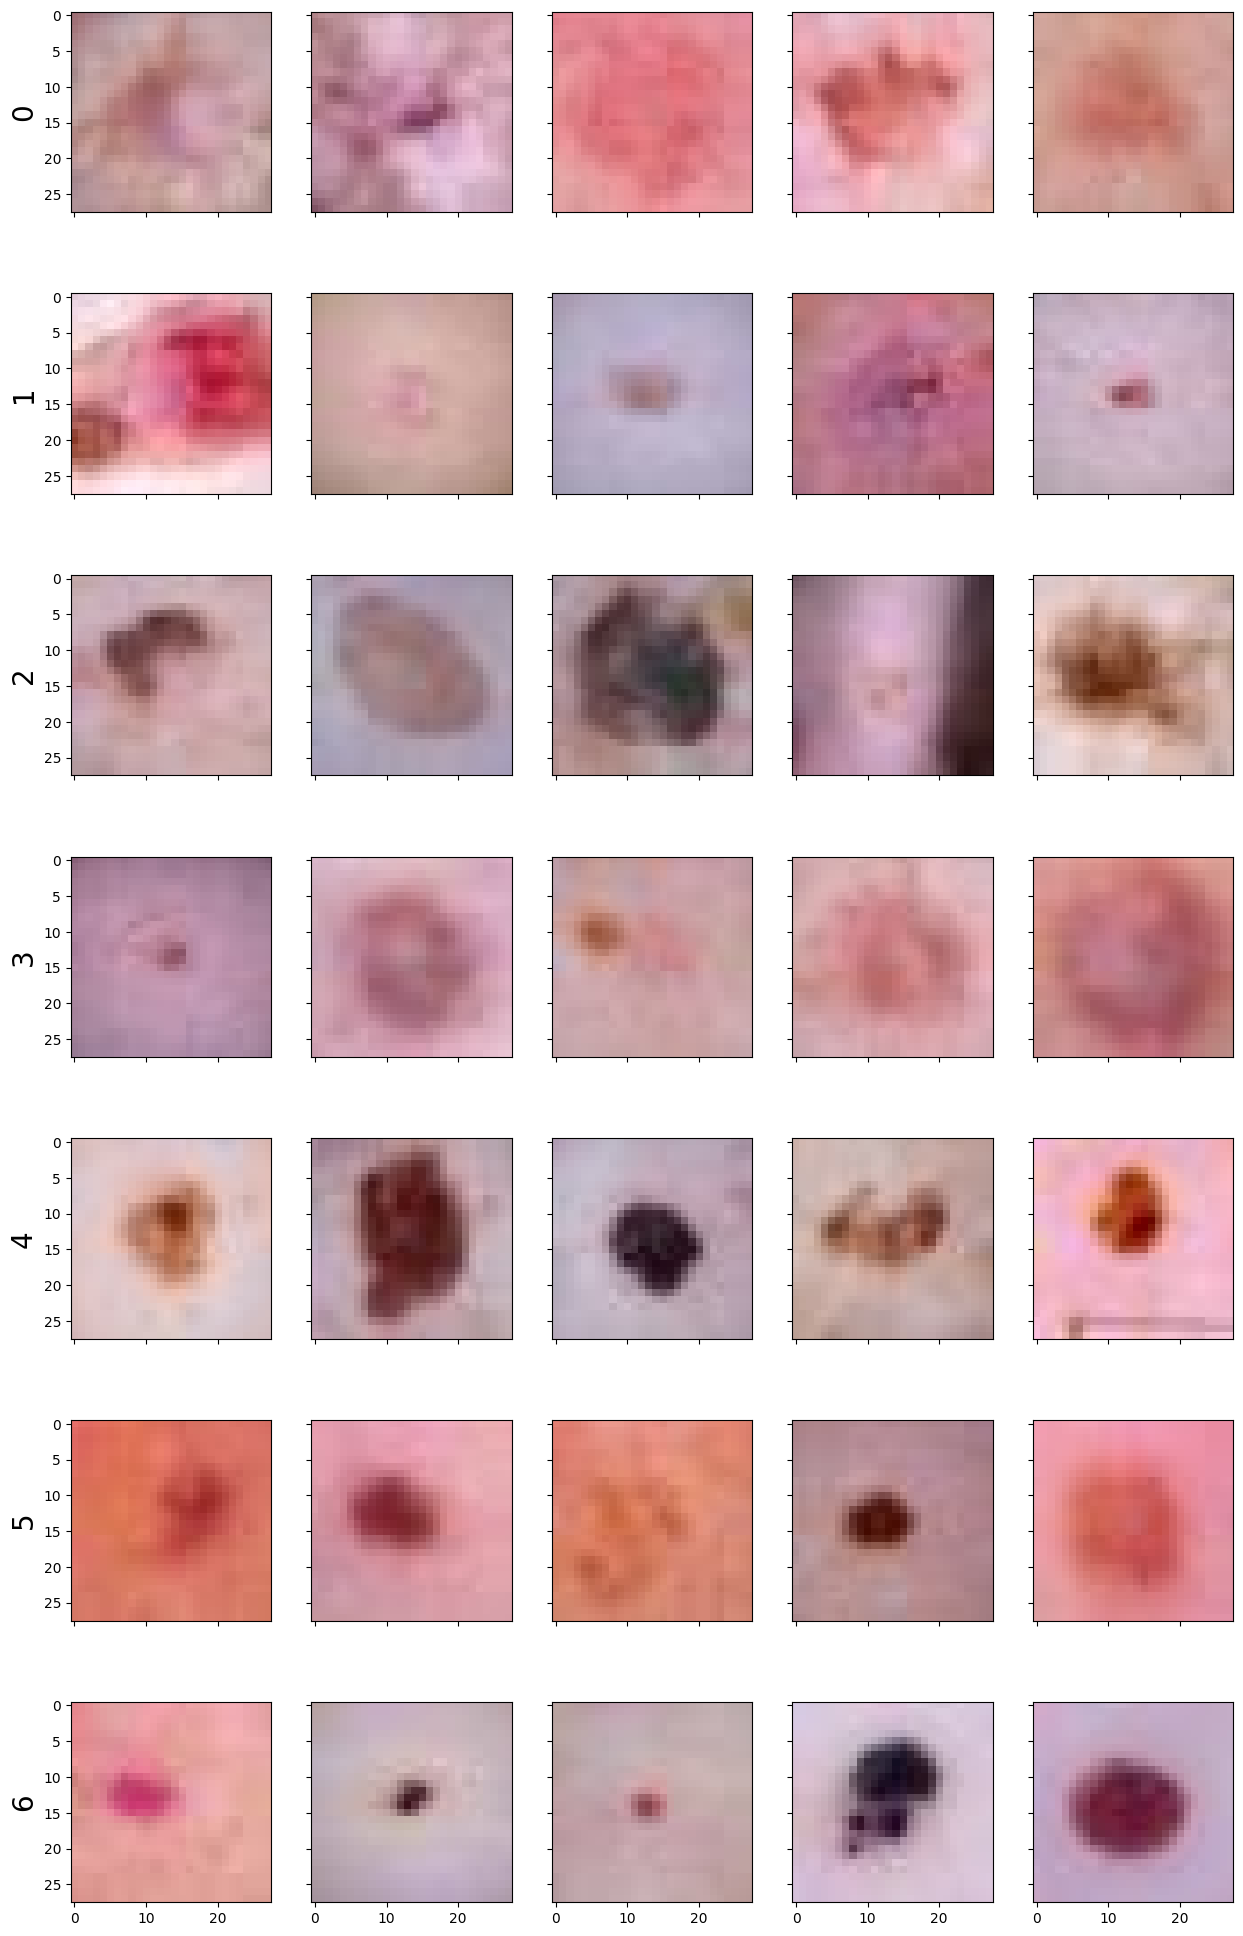

In [ ]:
fig, ax = plt.subplots(7, 5)
fig.set_figheight(25)
fig.set_figwidth(15)
for classes in range (7):
  for i, inx in enumerate(np.where(dataset_y_all==classes)[0][:5]):
    ax[classes,i].imshow(dataset_x_all[inx])
    ax[classes,i].set_ylabel(classes,fontsize = 20.0)
    ax[classes,i].label_outer()

In [ ]:
dataset_train.labels


array([[0],
       [5],
       [5],
       ...,
       [2],
       [5],
       [5]], dtype=uint8)

In [ ]:
import pandas as pd

labels = [0,1,2,3,4,5,6]

num_classes = []
for i in range(len(labels)):
  num_classes.append(len(np.where(dataset_train.labels==i)[0]))

pd.DataFrame(num_classes,index=labels)

,0
0,228
1,359
2,769
3,80
4,779
5,4693
6,99


In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

os_dict = {0: num_classes[0]*7,
           1: num_classes[1]*5,
           2: 1500,
           3: 2500,
           4: 1500,
           5: num_classes[5],
           6: 1500}
oversample = RandomOverSampler(sampling_strategy=os_dict)
oversampled_X , oversampled_y = oversample.fit_resample(dataset_train.imgs.reshape(dataset_train.imgs.shape[0], -1), dataset_train.labels)
print('OS_X:%s OS_y:%s' %(oversampled_X.shape, oversampled_y.shape))

us_dict = {0: num_classes[0]*7,
           1: num_classes[1]*5,
           2: 1500,
           3: 2500,
           4: 1500,
           5: 3000,
           6: 1500}

undersample = RandomUnderSampler(sampling_strategy=us_dict)
undersampled_X , undersampled_y = undersample.fit_resample(oversampled_X, oversampled_y)
print('US_X:%s US_y:%s' %(undersampled_X.shape, undersampled_y.shape))

OS_X:(15084, 2352) OS_y:(15084,)
US_X:(13391, 2352) US_y:(13391,)


In [ ]:
undersampled_y.shape

(13391,)

In [ ]:
undersampled_X.shape

(13391, 2352)

In [ ]:
undersampled_X = undersampled_X.reshape(-1,28,28,3)

In [ ]:
num_classes = []
for i in range(len(labels)):
  num_classes.append(len(np.where(undersampled_y==i)[0]))

pd.DataFrame(num_classes,index=labels)

,0
0,1596
1,1795
2,1500
3,2500
4,1500
5,3000
6,1500


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
y_val = dataset_val.labels
y_test = dataset_test.labels

In [ ]:
print(undersampled_y.shape)
print(dataset_val.labels.shape)
print(dataset_test.labels.shape)

(13391,)
(1003, 1)
(2005, 1)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 10,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = 'wrap')

batch_size=50
train_data = train_datagen.flow(undersampled_X, undersampled_y, batch_size = batch_size, seed=1)

test_datagen = ImageDataGenerator(rescale = 1./255)
val_data = test_datagen.flow(dataset_val.imgs, dataset_val.labels, batch_size=batch_size,seed=1)
print(np.argmax(val_data.y, axis=0))

[25]


In [ ]:
print(f'Train Set:      X:%s Y:%s' %(train_data.x.shape, train_data.y.shape))
print(f'Validation Set: X:%s Y:%s' %(val_data.x.shape, dataset_val.labels.shape))
print(f'Test Set :      X:%s Y:%s' %(dataset_test.imgs.shape, dataset_test.labels.shape))

Train Set:      X:(13391, 28, 28, 3) Y:(13391,)
Validation Set: X:(1003, 28, 28, 3) Y:(1003, 1)
Test Set :      X:(2005, 28, 28, 3) Y:(2005, 1)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score


X_train_flat = train_data.x.reshape(train_data.x.shape[0], -1)
X_test_flat = dataset_test.imgs.reshape(dataset_test.imgs.shape[0], -1)

# Trenowanie modelu
classifier = RandomForestClassifier(n_estimators=200,
                                    criterion='entropy',
                                    random_state=5,
                                    max_features="sqrt"
                                   )
classifier.fit(X_train_flat, train_data.y)

# Przewidywanie etykiet dla danych testowych
y_pred_rand_tree = classifier.predict(X_test_flat)

In [ ]:
# Obliczanie dokładności modelu
accuracy = accuracy_score(y_test, y_pred_rand_tree)
print("Dokładność: {:.2f}".format(accuracy))

# Obliczanie F1 score modelu
f1 = f1_score(y_test, y_pred_rand_tree, average='weighted')
print("F1 score: {:.2f}".format(f1))

Dokładność: 0.72
F1 score: 0.70


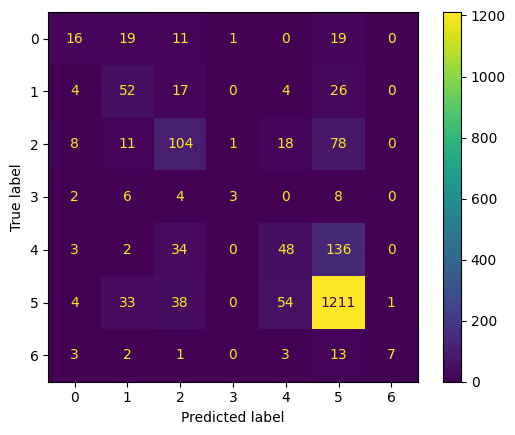

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

confusion_matrix = metrics.confusion_matrix(y_test, y_pred_rand_tree)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = labels)

cm_display.plot()
plt.show()